In [1]:
import os , sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

from numpy import log
from pandas import Series
from datetime import datetime

## IMPORTING AIRLINE DATA

In [2]:
airline = pd.read_csv("C:\\Users\\siddh\\OneDrive\\Desktop\\SQL\\SQL DATASET\\airline_passengers.csv")
airline.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Checking for missing data

In [3]:
airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

### Dataset Information

In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


-  **Month is object type and we have to convert it into datetime format**

### Converting Month column into datetime format

In [5]:
airline['Month'] = pd.to_datetime(airline['Month'])

- **Date is 01 by default in a datetime format if no date is given**

### dataset information


In [6]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [7]:
airline.head()

,Month,Thousands of Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Making Month column as index 

In [8]:
airline.set_index('Month',inplace=True)

In [9]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Plotting Month vs Number of passengers plot

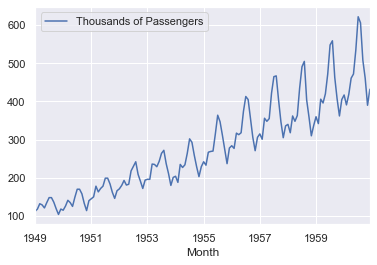

In [10]:
airline.plot()
plt.show()

- **Seasonality is there**
- **Upward trend is there**
- **same pattern till end , so it is an additive model**

### Decomposition to check dataset pattern/component

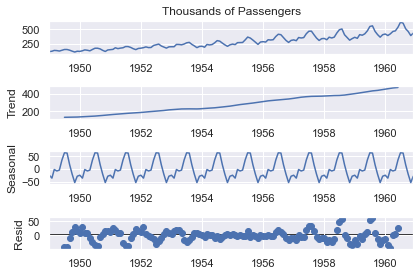

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(airline['Thousands of Passengers'],model='additive',period=12)
decomposition.plot()
plt.show()

## Checking for Autocorrelation in the data

In [12]:
# Durbin Watson Test 
import statsmodels.api as sm 
sm.stats.durbin_watson(airline['Thousands of Passengers'])

0.0121527966037621

- **There is a positive autocorrelation , so we can not solve by linear regression**

- **we have to solve using TSF**

## Check whether time series is stationary or not

In [13]:
#Augmented Dickey-fuller test
from statsmodels.tsa.stattools import adfuller

In [14]:
adfuller(airline['Thousands of Passengers'])

(0.8153688792060411,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [15]:
# function for the ADF Test

def adf_check(timeseries):
    result = adfuller(timeseries)
    print("*********AUGMENTED DICKEY-FULLER TEST*********")
    labels = ['ADF Stats value','P-value','#Lags','No. of Observations']
    
    for a,b in zip(result,labels):
        print(b,' : ',str(a))
        
    if result[1] <= 0.05 :
        print("Strong evidence against Null hypothesis and my timeseries is Stationary")
        
    else:
        print("Weak Evidence against Null hypothesis and my timeseries is Non-Stationary")

In [16]:
adf_check(airline['Thousands of Passengers'])

*********AUGMENTED DICKEY-FULLER TEST*********
ADF Stats value  :  0.8153688792060411
P-value  :  0.9918802434376409
#Lags  :  13
No. of Observations  :  130
Weak Evidence against Null hypothesis and my timeseries is Non-Stationary


## Making Dataset Stationary(Trend - d)

- Use lag function
- Find the difference
- shift(value) is used to find the lag values i.e one above the value

In [17]:
#Finding 1st Lag
airline['1st Diff'] = airline['Thousands of Passengers'] - airline['Thousands of Passengers'].shift(1)

In [18]:
airline.head()

,Thousands of Passengers,1st Diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [19]:
adf_check(airline['1st Diff'].dropna())

*********AUGMENTED DICKEY-FULLER TEST*********
ADF Stats value  :  -2.8292668241699945
P-value  :  0.05421329028382621
#Lags  :  12
No. of Observations  :  130
Weak Evidence against Null hypothesis and my timeseries is Non-Stationary


In [20]:
#Finding 2nd Diff
airline['2nd diff'] = airline['1st Diff'] - airline['1st Diff'].shift(1)

In [21]:
airline.head()

,Thousands of Passengers,1st Diff,2nd diff
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [22]:
 adf_check(airline['2nd diff'].dropna())

*********AUGMENTED DICKEY-FULLER TEST*********
ADF Stats value  :  -16.384231542468466
P-value  :  2.732891850014397e-29
#Lags  :  11
No. of Observations  :  130
Strong evidence against Null hypothesis and my timeseries is Stationary


-  ** d = 2  as we are calculating trend**

## Stationarity for Seasonality(D)

In [23]:
# Using difference value of 12 months 
airline['seasonality'] = airline['Thousands of Passengers'] - airline['Thousands of Passengers'].shift(12)

In [24]:
airline.head(20)

,Thousands of Passengers,1st Diff,2nd diff,seasonality
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN
1949-06-01,135,14.0,22.0,NaN
1949-07-01,148,13.0,-1.0,NaN
1949-08-01,148,0.0,-13.0,NaN
1949-09-01,136,-12.0,-12.0,NaN


In [25]:
# Checking for stationary for seasonality column
adf_check(airline['seasonality'].dropna())

*********AUGMENTED DICKEY-FULLER TEST*********
ADF Stats value  :  -3.3830207264924814
P-value  :  0.011551493085514952
#Lags  :  1
No. of Observations  :  130
Strong evidence against Null hypothesis and my timeseries is Stationary


- *D=1*

In [26]:
# Importing autocorrelation and partial autorcorrelation func
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

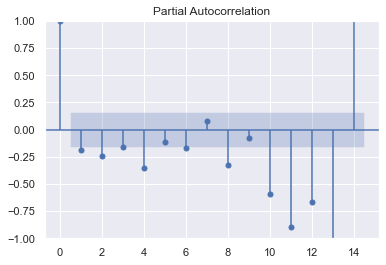

In [27]:
# Partial autocorr for trend(p)
plot_pacf(airline['2nd diff'].dropna(),lags=14)  #Trend for 14 months
plt.show()

In [28]:
# p = 4

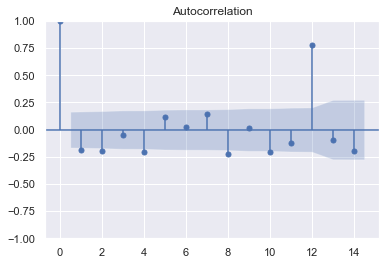

In [29]:
#Auto correlation for trend(q)
plot_acf(airline['2nd diff'].dropna(),lags=14)
plt.show()

In [30]:
# q = 2

In [31]:
#trend(p,d,q) = (4,2,2)

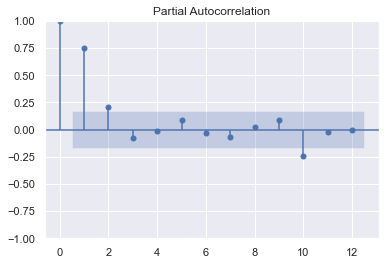

In [32]:
# Partial autocorr for seasonality(P)
plot_pacf(airline['seasonality'].dropna(),lags=12)  #Seaonality for 12 months
plt.show()

In [33]:
# P = 2

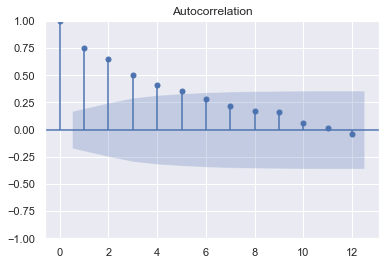

In [34]:
#Auto correlation for seasonality(Q)
plot_acf(airline['seasonality'].dropna(),lags=12)
plt.show()

In [35]:
# Q = 5 

In [36]:
#trend(p,d,q) = (4,2,2)
#seasonality(P,D,Q) = (2,1,5)

## ARIMA MODEL

In [37]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [38]:
model = sm.tsa.statespace.SARIMAX(airline['Thousands of Passengers'],order=(4,2,2),
                                  seasonal_order = (2,1,5,12))

C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [39]:
result = model.fit()

C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
#Summary
print(result.summary())

                                            SARIMAX Results                                             
Dep. Variable:                          Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -496.705
Date:                                          Fri, 19 May 2023   AIC                           1021.410
Time:                                                  15:43:46   BIC                           1061.556
Sample:                                              01-01-1949   HQIC                          1037.723
                                                   - 12-01-1960                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

In [41]:
# Model performance for Q = 4
model = sm.tsa.statespace.SARIMAX(airline['Thousands of Passengers'],order=(4,2,2),
                                  seasonal_order = (2,1,4,12))

result = model.fit()
print(result.summary())

C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                           
Dep. Variable:                       Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4], 12)   Log Likelihood                -497.020
Date:                                       Fri, 19 May 2023   AIC                           1020.039
Time:                                               15:43:55   BIC                           1057.317
Sample:                                           01-01-1949   HQIC                          1035.187
                                                - 12-01-1960                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3722     

In [42]:
# Model performance for Q = 3
model = sm.tsa.statespace.SARIMAX(airline['Thousands of Passengers'],order=(4,2,2),
                                  seasonal_order = (2,1,3,12))

result = model.fit()
print(result.summary())

C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         SARIMAX Results                                          
Dep. Variable:                    Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -497.189
Date:                                    Fri, 19 May 2023   AIC                           1018.378
Time:                                            15:44:01   BIC                           1052.788
Sample:                                        01-01-1949   HQIC                          1032.360
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3700      0.097    -14.163      0

In [43]:
# Model performance for Q = 2
model = sm.tsa.statespace.SARIMAX(airline['Thousands of Passengers'],order=(4,2,2),
                                  seasonal_order = (2,1,2,12))

result = model.fit()
print(result.summary())

C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:            Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, 2, 12)   Log Likelihood                -497.783
Date:                            Fri, 19 May 2023   AIC                           1017.565
Time:                                    15:44:03   BIC                           1049.108
Sample:                                01-01-1949   HQIC                          1030.382
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3579      0.099    -13.683      0.000      -1.552      -1.163
ar.L2         -0.4923      0.145   

In [44]:
# Model performance for Q = 1
model = sm.tsa.statespace.SARIMAX(airline['Thousands of Passengers'],order=(4,2,2),
                                  seasonal_order = (2,1,1,12))

result_final = model.fit()
print(result_final.summary())

C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:              Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1], 12)   Log Likelihood                -497.786
Date:                              Fri, 19 May 2023   AIC                           1015.573
Time:                                      15:44:07   BIC                           1044.248
Sample:                                  01-01-1949   HQIC                          1027.224
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3576      0.096    -14.155      0.000      -1.546      -1.170
ar.L2         -0.49

In [45]:
# Model: SARIMAX(4, 2, 2)x(2, 1, 5, 12) ------ AIC = 1021
# Model: SARIMAX(4, 2, 2)x(2, 1, 4, 12) ------ AIC = 1020.039
# Model: SARIMAX(4, 2, 2)x(2, 1, 5, 12) ------ AIC = 1018.378
# Model: SARIMAX(4, 2, 2)x(2, 1, 5, 12) ------ AIC = 1017.565
# Model: SARIMAX(4, 2, 2)x(2, 1, 5, 12) ------ AIC = 1015.573


## Forecasting on existing data

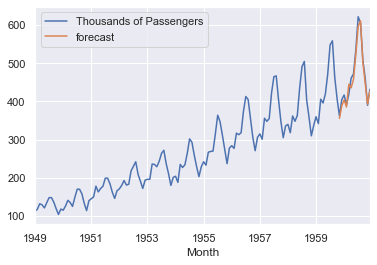

In [46]:
airline['forecast'] = result_final.predict(start=130,end=144,dynamic = True)
airline[['Thousands of Passengers','forecast']].plot()
plt.show()

## Predicting for next 5 years data

In [47]:
airline.tail()

,Thousands of Passengers,1st Diff,2nd diff,seasonality,forecast
Month,,,,,
1960-08-01,606,-16.0,-103.0,47.0,611.487099
1960-09-01,508,-98.0,-82.0,45.0,503.484826
1960-10-01,461,-47.0,51.0,54.0,448.485808
1960-11-01,390,-71.0,-24.0,28.0,393.244277
1960-12-01,432,42.0,113.0,27.0,426.544174


In [48]:
from pandas.tseries.offsets import DateOffset

In [49]:
future_dates = [(airline.index[-1] + DateOffset(months=x)) for x in range(61)]

In [50]:
future_dates

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-

In [51]:
# Creating dataframe for future data
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=airline.columns)

In [52]:
future_dates_df

,Thousands of Passengers,1st Diff,2nd diff,seasonality,forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN
1961-06-01,NaN,NaN,NaN,NaN,NaN
1961-07-01,NaN,NaN,NaN,NaN,NaN
1961-08-01,NaN,NaN,NaN,NaN,NaN
1961-09-01,NaN,NaN,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN,NaN,NaN


In [53]:
#concatenating existing and future data 

future_df = pd.concat([airline,future_dates_df])

In [54]:
future_df.head()

,Thousands of Passengers,1st Diff,2nd diff,seasonality,forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN


In [55]:
future_df.tail()

,Thousands of Passengers,1st Diff,2nd diff,seasonality,forecast
1965-08-01,NaN,NaN,NaN,NaN,NaN
1965-09-01,NaN,NaN,NaN,NaN,NaN
1965-10-01,NaN,NaN,NaN,NaN,NaN
1965-11-01,NaN,NaN,NaN,NaN,NaN
1965-12-01,NaN,NaN,NaN,NaN,NaN


In [56]:
len(future_df)

204

## FORECAST FOR NEXT 5 YEARS

<Figure size 1440x720 with 0 Axes>

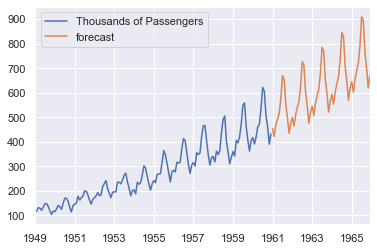

In [57]:
future_df['forecast'] = result_final.predict(start=144,end=204,dynamic=True)
plt.figure(figsize=(20,10))
future_df[['Thousands of Passengers','forecast']].plot()
plt.show()

In [58]:
# FORECAST DATA
future_df.tail(60)

,Thousands of Passengers,1st Diff,2nd diff,seasonality,forecast
1961-01-01,NaN,NaN,NaN,NaN,454.128991
1961-02-01,NaN,NaN,NaN,NaN,421.756600
1961-03-01,NaN,NaN,NaN,NaN,469.982800
1961-04-01,NaN,NaN,NaN,NaN,492.173453
1961-05-01,NaN,NaN,NaN,NaN,515.961954
1961-06-01,NaN,NaN,NaN,NaN,574.180788
1961-07-01,NaN,NaN,NaN,NaN,669.618662
1961-08-01,NaN,NaN,NaN,NaN,657.075514
1961-09-01,NaN,NaN,NaN,NaN,554.697005
1961-10-01,NaN,NaN,NaN,NaN,499.215455
